# Data Science Bowl 2019/2020:
### EDA/ Features

### Problem Statement
*The intent of the competition is to use the gameplay data to forecast how many attempts a child will take to pass a given assessment (an incorrect answer is counted as an attempt).*

### Data
Kaggle gives us five data files:
- <b>train.csv and test.csv</b>: both have 11 features (including detailed nested event-level data if we want to use it) corresponding to event_ids within game session ids, which can be aggregated by installation id
- <b>train_labels.csv</b>: includes accuracy group assignments for some of the train ids and a demonstration of how correct/incorrect answers map to accuracy group
- <b>specs.csv</b>: details on what parts of gameplay are represented by the event_ids
- <b>sample_submission.csv</b>: submission files must include two columns: the installation ID and predicted 'accuracy group.' 

<a href='https://www.kaggle.com/c/data-science-bowl-2019/data'> An overview of the features in each file can be found here.</a>

#### CONTENTS:

A. EDA
1. <a href=#events>Events</a>
2. <a href=#outcomes>Outcomes</a>
3. <a href=#time>Time/Game Flow</a>

B. <a href=#modelprep>Data for Modeling</a>

C. <a href=#feateng>Feature Engineering</a>

D. <a href=#transform>Transforming Train/Test</a>


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

sns.set(style='darkgrid')
plt.style.use('dark_background')
pd.set_option('max_colwidth', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [2]:
train = pd.read_csv('./data/train.csv')
labels = pd.read_csv('./data/train_labels.csv')
specs = pd.read_csv('./data/specs.csv')
test = pd.read_csv('./data/test.csv')

print("Shape of train: {}".format(train.shape))
print("Shape of test: {}".format(test.shape))
print("Shape of labels: {}".format(labels.shape))
print("Shape of specs: {}".format(specs.shape))

Shape of train: (11341042, 11)
Shape of test: (1156414, 11)
Shape of labels: (17690, 7)
Shape of specs: (386, 3)


### 1. Events<a name='events' />

In the Train dataset, each row represents one action in the app. While there are many unique event_ids, there are ~40 event codes that have basic gameplay elements in common across activities. Knowing what the event_codes represent would give us a better idea of what events matter most.

In [3]:
# making dictionary of event codes to event ids
codes = train[['event_id', 'event_code']].drop_duplicates()
codes_dict = dict(zip(list(codes['event_id']), list(codes['event_code'])))
# specs table doesn't have event_ids, so mapping codes to specs table
specs['event_code'] = specs['event_id'].map(codes_dict)
specs['event_code'].fillna(0, inplace = True)
specs['event_code'] = specs['event_code'].astype(int)

specs.sort_values(by = 'event_code').head(1)

,event_id,info,args,event_code
136,b738d3d3,The exit game event is triggered when the game is quit. This is used to compute things like time spent in game. Depending on platform this may / may not be possible. NOTE: “quit” also means navigating away from game.,"[{""name"":""game_time"",""type"":""int"",""info"":""millisecond count since start of gamemillisecond count since start of game""},{""name"":""round"",""type"":""int"",""info"":""number of the current round when the event takes place or 0 if no round""},{""name"":""session_duration"",""type"":""int"",""info"":""millisecond count since start of game""},{""name"":""exit_type"",""type"":""string"",""info"":""\""closed container\"", \""game ended\"", or browser exit/navigation""},{""name"":""event_count"",""type"":""int"",""info"":""session event counter""},{""name"":""event_code"",""type"":""int"",""info"":""event class identifier""}]",0


^ I went through the sorted specs table to see what the event ids had in common, and generated these manual labels (there's a more DS way to do that but doing it manually didn't take that long)

In [4]:
# event code labels - generated by looking at event ids. Some of these appear to be duplicated, 
# like 'Gameplay' - for those, I couldn't tell what made the codes unique/belong to one group

specs_dict = {0: 'Exit Game',
             2000: 'Start Game',
             2010: 'Exit Game',
             2020: 'Start Round',
             2025: 'Gameplay - New Phase',
             2030: 'Beat Round',
             2035: 'Beat Round',
             2040: 'Start New Level',
             2050: 'Beat Level',
             2060: 'Start Tutorial/Round',
             2070: 'Finished Tutorial',
             2075: 'Beat Round: End of Tutorial',
             2080: 'Movie Started',
             2081: 'Movie Skipped',
             2083: 'Movie Ended',
             3010: 'Extra Instructions',
             3020: 'Start Feedback (Incorrect)',
             3021: 'Start Feedback (Correct)',
             3110: 'End Instructions',
             3120: 'End Feedback (Incorrect)',
             3121: 'End Feedback (Correct)',
             4010: 'Click Start',
             4020: 'Gameplay - Click',
             4021: 'Gameplay - Fill',
             4022: 'Gameplay - Place',
             4025: 'Gameplay',
             4030: 'Gameplay - Pick Up',
             4031: 'Gameplay',
             4035: 'Gameplay - Drag',
             4040: 'Gameplay',
             4045: 'Gameplay',
             4050: 'Gameplay',
             4070: 'Gameplay - Distraction',
             4080: 'Gameplay - Hover',
             4090: 'Request Help',
             4095: 'Play Again',
             4100: 'Submit Answer',
             4110: 'Submit Answer',
             4220: 'Victory Screen Click',
             4235: 'Toy Drag',
             5000: 'Gameplay',
             5010: 'Gameplay'
             }

In [5]:
# mapping new labels to codes in train
# train2 = train.copy()
#train2['event_type'] = train2['event_code'].map(specs_dict)

### 2. Outcomes<a name='labels' />

*The outcomes in this competition are grouped into 4 groups (labeled accuracy_group in the data):*

- 3: the assessment was solved on the first attempt
- 2: the assessment was solved on the second attempt
- 1: the assessment was solved after 3 or more attempts
- 0: the assessment was never solved

*The file train_labels.csv has been provided to show how these groups would be computed on the assessments in the training set. Assessment attempts are captured in event_code 4100 for all assessments except for Bird Measurer, which uses event_code 4110. If the attempt was correct, it contains "correct":true.*

In [6]:
labels['game_session'].nunique() # all game sessions are unique, installation IDs are not

17690

In [7]:
labels.head()

,game_session,installation_id,title,num_correct,num_incorrect,accuracy,accuracy_group
0,6bdf9623adc94d89,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
1,77b8ee947eb84b4e,0006a69f,Bird Measurer (Assessment),0,11,0.0,0
2,901acc108f55a5a1,0006a69f,Mushroom Sorter (Assessment),1,0,1.0,3
3,9501794defd84e4d,0006a69f,Mushroom Sorter (Assessment),1,1,0.5,2
4,a9ef3ecb3d1acc6a,0006a69f,Bird Measurer (Assessment),1,0,1.0,3


##### Which Assessments Are the Hardest?

In [8]:
# fifty percent of assessments were completed on the first try
labels['accuracy_group'].value_counts(normalize = True)

3    0.500000
0    0.239062
1    0.136292
2    0.124647
Name: accuracy_group, dtype: float64

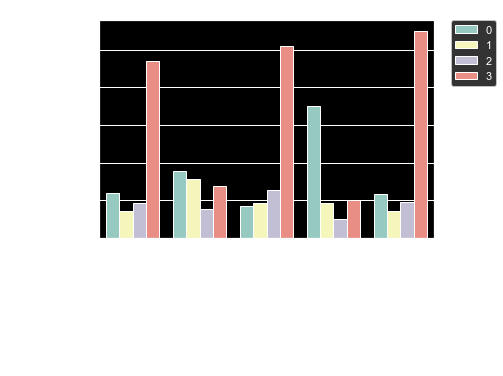

In [9]:
ax = sns.countplot(x="title", hue = "accuracy_group", data=labels)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title("Which Assessments Are the Hardest?")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

In [10]:
# performance by assessment
labels.groupby('title')['accuracy_group'].value_counts(normalize = True)

title                         accuracy_group
Bird Measurer (Assessment)    0                 0.322651
                              1                 0.283321
                              3                 0.252367
                              2                 0.141661
Cart Balancer (Assessment)    3                 0.662973
                              0                 0.138762
                              2                 0.113226
                              1                 0.085040
Cauldron Filler (Assessment)  3                 0.627620
                              2                 0.155364
                              1                 0.113194
                              0                 0.103822
Chest Sorter (Assessment)     0                 0.587722
                              3                 0.170077
                              1                 0.156323
                              2                 0.085877
Mushroom Sorter (Assessment)  3            

The most difficult assessment is Chest Sorter (17% solve on first try), followed by Bird Measurer (25% solve on first try), followed by Mushroom Sorter (62.5%), then Cauldron Filler (62.7%), and finally the easiest assessment: Cart Balancer (66% solved on first try). 

The 'hardest' assessments (ones least solved on first try) are also the ones most frequently abandoned before they are solved (58% never solve Chest Sorter; 32% never solve Bird Measurer, etc.)

### 3. Time Features<a name='time' />

We're given some temporal data in train and test: the time taken for each event_id/step in the game (in miliseconds), and the timestamp for the beginning of each step in the game. We could use this information to get an idea of how much time is spent on each activity per device.

In [11]:
def fix_time(df):
    # convert timestamp to timestamp
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    # converts milliseconds to seconds
    df['game_time_s'] = df['game_time'] / 1000
    # calculates the time for each game step, replaces negatives with 0
    df['step_time'] = df['game_time_s'].diff().clip_lower(0)
    return df

##### Aggregating Game Sessions/Total Time

In [12]:
# making copy of train
train2 = fix_time(train)

In [13]:
train2.head()

,event_id,game_session,timestamp,event_data,installation_id,event_count,event_code,game_time,title,type,world,game_time_s,step_time
0,27253bdc,45bb1e1b6b50c07b,2019-09-06 17:53:46.937,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Welcome to Lost Lagoon!,Clip,NONE,0.000,NaN
1,27253bdc,17eeb7f223665f53,2019-09-06 17:54:17.519,"{""event_code"": 2000, ""event_count"": 1}",0001e90f,1,2000,0,Magma Peak - Level 1,Clip,MAGMAPEAK,0.000,0.000
2,77261ab5,0848ef14a8dc6892,2019-09-06 17:54:56.302,"{""version"":""1.0"",""event_count"":1,""game_time"":0,""event_code"":2000}",0001e90f,1,2000,0,Sandcastle Builder (Activity),Activity,MAGMAPEAK,0.000,0.000
3,b2dba42b,0848ef14a8dc6892,2019-09-06 17:54:56.387,"{""description"":""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"",""identifier"":""Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape"",""media_type"":""audio"",""total_duration"":6758,""event_count"":2,""game_time"":53,""event_code"":3010}",0001e90f,2,3010,53,Sandcastle Builder (Activity),Activity,MAGMAPEAK,0.053,0.053
4,1bb5fbdb,0848ef14a8dc6892,2019-09-06 17:55:03.253,"{""description"":""Let's build a sandcastle! First, fill up your mold with sand! You can use the shovel here. The mold gives the sand its shape!"",""identifier"":""Dot_LetsSandcastle,Dot_FillMold,Dot_MoldShape"",""media_type"":""audio"",""duration"":6919,""event_count"":3,""game_time"":6972,""event_code"":3110}",0001e90f,3,3110,6972,Sandcastle Builder (Activity),Activity,MAGMAPEAK,6.972,6.919


In [14]:
# generating total game sessions per device
sessions_dict = train.groupby('installation_id').agg({'game_session': lambda x: x.nunique()}).to_dict()['game_session']
train2['total_game_sessions'] = train2['installation_id'].map(sessions_dict)
# total time
time_dict = train.groupby('installation_id').agg({'step_time': np.sum}).to_dict()['step_time']
train2['total_game_time'] = train2['installation_id'].map(time_dict)
# convert milliseconds to seconds

# generating new df to look at just aggregate data
aggs = train2[['installation_id', 'total_game_sessions', 'total_game_time']]

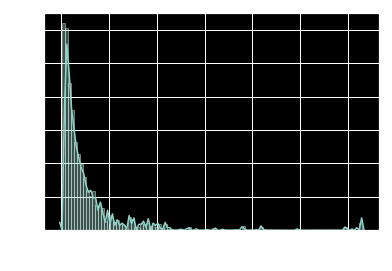

In [15]:
# number of game sessions per installation id
ax = sns.distplot(aggs['total_game_sessions'], bins=100);

In [16]:
# converting aggs total game time to hours
aggs['total_game_time_hrs'] = aggs['total_game_time'] / 3600

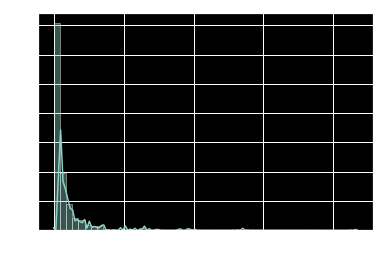

In [17]:
ax = sns.distplot(aggs['total_game_time_hrs']);

In [18]:
aggs.describe()

,total_game_sessions,total_game_time,total_game_time_hrs
count,1.134104e+07,1.134104e+07,1.134104e+07
mean,9.866712e+01,1.028074e+04,2.855762e+00
std,1.528496e+02,1.998563e+04,5.551564e+00
min,1.000000e+00,0.000000e+00,0.000000e+00
25%,2.100000e+01,1.356645e+03,3.768458e-01
50%,5.000000e+01,3.889574e+03,1.080437e+00
75%,1.120000e+02,1.056166e+04,2.933794e+00
max,1.260000e+03,3.129583e+05,8.693285e+01


## B. Data for Models<a name='modelprep' />
The data isn't structured for an easy, immediate join between the training data and target variable...

#### Filter Installation IDs that are in Train_labels
Not all training set installation_ids are in the labels set; if we want to be able to evaluate results from gameplay, we should filter training data to the ones that have an assessment.

In [19]:
# function to filter to assessed only
def filter_assessed(train_df, labels_df):
    install_ids = list(labels_df['installation_id'].unique())
    new_df = train_df[train_df['installation_id'].isin(install_ids)]
    return new_df

assessed = filter_assessed(train, labels)
print(assessed.shape)

(7734558, 15)


#### Comparing Train to Train_Labels
Train_labels has more than one accuracy_group score for each installation_id. So for training purposes, if we want to use all the train_labels we need to join results on game session ids. Because we know when each game session occurred, we can aggregate all the installation_id information that happened prior to and during that game session, and make that the data we use to predict the outcome for that game_session id. 

In [20]:
def sort_by_time(df):
    new_df = df.sort_values(by = ['installation_id', 'timestamp'], ascending = True)
    return new_df

# ordering assessed by timestamp and installation id - this will also sort by game session
assessed = sort_by_time(assessed)

# check to make sure game sessions in labels all exist in training data
print(labels[labels['game_session'].isin(assessed['game_session'])].shape)
print(labels.shape)

(17690, 7)
(17690, 7)


#### Comparing Test to Train
*In the training set, you are provided the full history of gameplay data. In the test set, we have truncated the history after the start event of a single assessment, chosen randomly, for which you must predict the number of attempts. Note that the training set contains many installation_ids which never took assessments, whereas every installation_id in the test set made an attempt on at least one assessment.*

The test set seems to be similar to the training dataset, except we won't need to filter out any that don't have a label/accuracy group. However, because the sample calls for us to submit accuracy groups for each installation id (not each game session like we have in the training labels), I think that means we will be pretending to allocate scores for new assessments (not in test) for each device, not knowing what assessments they are, and predict performance based solely on past performance. 

In [21]:
print(test.shape)
print(test['game_session'].nunique())
print(test['installation_id'].nunique())

(1156414, 11)
28445
1000


## C. Feature Engineering<a name='feateng' />

Based on the information we will have for the test data (past app experience) and the data we won't (what assessment we are generating an accuracy score for), we might want to focus on building features that aggregate past experience (leading up to the current game session):

1. How much time has been spent on the app (in general, on each activity, on assessments, etc.)
2. How many times they've taken assessments/played games
3. How well they did on past assessments/games

We could guess that players are more likely to pass assessments quickly if they a) have tried those assessments before, b) have practiced activities that use the skills tested in the assessments (which we can only know if they've been to all worlds/done a variety of activities) c) have generally spent more time in the application and understand how the rules/ interface/ gameplay works. Players that are new to the app are probably more likely to need more tries to pass assessments.

##### Correct / Incorrect Gameplay / Answers
Answer submissions for assessments are event code 4100 or 4110 and outcomes are marked in event_data either "correct": true or "correct": false. We can look at codes 3021 and 3020 which give feedback based on right or wrong attempts in games.

In [ ]:
def correct_incorrect(df):
    # gameplay
    df['game_correct'] = [1 if i == 3021 else 0 for i in df['event_code']]
    df['game_incorrect'] = [1 if i == 3020 else 0 for i in df['event_code']]
    
    # assessments
    answers = df[(df['event_code'] == 4100) | (df['event_code']==4110)]
    correct = [1 if '"correct":true' in i else 0 for i in df['event_data']]
    incorrect = [1 if '"correct":false' in i else 0 for i in df['event_data']]
    
    correct_dict = dict(zip(list(answers.index), correct))
    incorrect_dict = dict(zip(list(answers.index), incorrect))

    df['test_correct'] = df.index.map(correct_dict)
    df['test_incorrect'] = df.index.map(incorrect_dict)
    
    # cumulative correct/incorrect assessment answers
    df['test_correct_cuma'] = df.groupby('installation_id')['test_correct'].cumsum(skipna=True)
    df['test_incorrect_cuma'] = df.groupby('installation_id')['test_incorrect'].cumsum(skipna=True)
    df['proportion_correct_cuma'] = df['test_correct_cuma']/(df['test_correct_cuma']
                                                                     + df['test_incorrect_cuma'])
    
    # cumulative correct/incorrect gameplay
    df['game_correct_cuma'] = df.groupby('installation_id')['game_correct'].cumsum(skipna=True)
    df['game_incorrect_cuma'] = df.groupby('installation_id')['game_incorrect'].cumsum(skipna=True)
    df['proportion_correct_game_cuma'] = df['game_correct_cuma']/(df['game_correct_cuma']
                                                                     + df['game_incorrect_cuma'])
    return df

#### Prior App Time / Number of Game Sessions

In [ ]:
def app_time(df):
    # prior app time
    df['app_time_cuma'] = df.groupby('installation_id')['step_time'].cumsum(skipna = True)
    
    # prior game sessions
    game_sessions = list(df['game_session'].unique())
    sessions_dict = dict(zip(game_sessions, list(range(len(game_sessions)))))
    
    # finding where new game sessions begin
    df['new_session_id'] = df['game_session'].map(sessions_dict)
    df['new_game'] = df['new_session_id'].diff()
    df.drop(columns=['new_session_id'], inplace =True)
    df['game_sessions_cuma'] = df.groupby('installation_id')['new_game'].cumsum(skipna = True)
    
    return df

#### Instructions
We know the game designers added a feature to give extra instructions (not triggered by a user event). We can use this and the information on duration spent reviewing instructions to see if that makes a difference in gameplay. Start extra instructions = code 3010. End instructions = code 3110. 

In [ ]:
def instructions(df):
    # number of times players got instructions, cumulatively
    df['got_instructions'] = [1 if i == 3010 else 0 for i in df['event_code']]
    df['got_instructions_cuma'] = df.groupby('installation_id')['got_instructions'].cumsum(skipna = True)
    
    # amount of time spend on instructions, cumulatively
    got_instructions_df = df[df['got_instructions']==1]
    got_instructions = df[df['got_instructions']==1].index
    instruction_time = got_instructions_df['step_time']
    time_dict = dict(zip(got_instructions, instruction_time))
    df['instruction_time'] = df.index.map(time_dict)
    df['instruction_time_cuma'] = df.groupby('installation_id')['instruction_time'].cumsum(skipna = True)
    
    return df

#### Installation IDs that have done Assessments Before
Some of the installation IDs in the train_labels dataset also have assessments in the train set; we can measure how many prior assessments they had and how much time they spent cumulatively.

In [ ]:
def prior_assessments(df):
    # number of prior assessments
    did_assess_df = df[df['type'] == 'Assessment']
    did_assess = did_assess_df.index

    number_assessments = did_assess_df.groupby('installation_id')['new_game'].cumsum(skipna = True)
    assess_dict = dict(zip(did_assess, number_assessments))
    df['prior_assessments_cuma'] = df.index.map(assess_dict)
    
    # amount of time spent on prior instructions, cumulatively
    assessment_time = did_assess_df['step_time']
    time_dict = dict(zip(did_assess, assessment_time))
    df['assessment_time'] = df.index.map(time_dict)
    df['assessment_time_cuma'] = df.groupby('installation_id')['assessment_time'].cumsum(skipna = True)
    
    return df

In [ ]:
# fill in the NANs
def fillna(df):
    df = df.fillna(0)
    return df

#### Aggregating by Activity
If we wanted, we could instead aggregate all the above by specific activities (games, assessments, etc.) or by the worlds they were in. 

In [ ]:
# aggregating number of game sessions and time spent per activity
activities = list(assessed[(assessed['type'] =='Activity')]['title'].unique())
assessments = list(assessed[(assessed['type'] == 'Assessment')]['title'].unique())
games = list(assessed[(assessed['type'] == 'Game')]['title'].unique())
worlds = list(assessed['world'].unique())

In [ ]:
def aggregate_by_activity(df, subset, subset_type = ['title', 'world']):
    subset_df = df[df[subset_type] == subset]
    subset_index = subset_df.index
    
    new_num = subset_df.groupby('installation_id')['new_game'].cumsum(skipna = True)
    new_time = subset_df.groupby('installation_id')['step_time'].cumsum(skipna = True)
    new_correct_t = subset_df.groupby('installation_id')['test_correct'].cumsum(skipna = True)
    new_incorrect_t = subset_df.groupby('installation_id')['test_incorrect'].cumsum(skipna = True)
    new_correct_g = subset_df.groupby('installation_id')['game_correct'].cumsum(skipna = True)
    new_incorrect_g = subset_df.groupby('installation_id')['game_incorrect'].cumsum(skipna = True)
    
    new_num_dict = dict(zip(subset_index, new_num))
    new_time_dict = dict(zip(subset_index, new_time))
    new_correct_t = dict(zip(subset_index, new_correct_t))
    new_incorrect_t = dict(zip(subset_index, new_incorrect_t))
    new_correct_g = dict(zip(subset_index, new_correct_g))
    new_incorrect_g = dict(zip(subset_index, new_incorrect_g))
    
    new_time_col = subset + '_totaltime_perid'
    new_num_col = subset + '_gamesessions_perid'
    new_correct_t_col = subset + '_correctanswers_perid'
    new_incorrect_t_col = subset + '_incorrectanswers_perid'
    new_correct_g_col = subset + '_correctplay_perid'
    new_incorrect_g_col = subset + '_incorrectplay_perid'
    new_correct_pct_t_col = subset + '_correctanswers_rate_perid'
    new_correct_pct_g_col = subset + '_correctplay_rate_perid'
    
    df[new_time_col] = df.index.map(new_time_dict)
    df[new_num_col] = df.index.map(new_num_dict)
    df[new_correct_t_col] = df.index.map(new_correct_t)
    df[new_incorrect_t_col] = df.index.map(new_incorrect_t)
    df[new_correct_g_col] = df.index.map(new_correct_g)
    df[new_incorrect_g_col] = df.index.map(new_incorrect_g)
    df[new_correct_pct_t_col] = df[new_correct_t_col] / (df[new_correct_t_col]+df[new_incorrect_t_col])
    df[new_correct_pct_g_col] = df[new_correct_g_col] / (df[new_correct_g_col]+df[new_incorrect_g_col])
    
    return df
 
def agg_func(df, iterlist, subset_type):
    for i in iterlist:
        aggregate_by_activity(df, i, subset_type)
    return df

### D. Transforming Train/Test<a name='transform' />

##### New Train

In [ ]:
## Apply functions to get new train dataset
# fix time
new_train = fix_time(train)
# filter by ones in labels
new_train = filter_assessed(new_train, labels)
# order by time and installation id
new_train = sort_by_time(new_train)
# add correct/incorrect features
new_train = correct_incorrect(new_train)
# add time features
new_train = app_time(new_train)
# add instructions features
new_train = instructions(new_train)
# add assessments features
new_train = prior_assessments(new_train)
# add aggregate information based on each world
new_train = agg_func(new_train, worlds, subset_type = 'world')
# fillna
new_train = fillna(new_train)

In [ ]:
unnecessary_features = ['event_id',
                       'timestamp',
                       'event_data',
                       'event_count',
                       'event_code',
                       'game_time',
                       'title',
                       'type',
                       'world']

game_sessions = list(labels['game_session'].unique())

In [ ]:
new_train = new_train.drop(columns = unnecessary_features)
new_train = new_train[new_train['new_game']==1]
new_train = new_train[new_train['game_session'].isin(game_sessions)]

In [ ]:
# checking we have the same # of rows for new_train and train_labels
print(new_train.shape)
print(labels.shape)

In [ ]:
new_train.dtypes # should be all ints and floats except for game_session and install_id

In [ ]:
new_train.to_csv('./data/new_train.csv')

##### New Test

In [ ]:
## Apply functions to get new train dataset
# fix time
new_test = fix_time(test)
# no need to filter test

# sort by time
new_test = sort_by_time(new_test)
# add correct/incorrect features
new_test = correct_incorrect(new_test)
# add time features
new_test = app_time(new_test)
# add instructions features
new_test = instructions(new_test)
# add assessments features
new_test = prior_assessments(new_test)
# add aggregate information based on each world
new_test = agg_func(new_test, worlds, subset_type = 'world')
# fillna
new_test = fillna(new_test)

In [ ]:
# drop same unnecessary features as train
new_test = new_test.drop(columns = unnecessary_features)

In [ ]:
# checking shape, should be same 
new_test.shape

In [ ]:
# instead of getting new game_sessions, we want the last row for each installation id
new_test = new_test.groupby('installation_id').last()

In [ ]:
# we should have 1000 rows for new_test
print(new_test.shape)

In [ ]:
new_test.head()

In [ ]:
new_test['installation_id'] = new_test.index

In [ ]:
new_test.head()

In [ ]:
new_test.to_csv('./data/new_test.csv')

### More Features?

We could also guess that players who are more invested in getting the assessments right would try more times and get more practice than those who get bored with the game and app easily. Is there a way to tell how 'focused' the players are? (Can we tell from the gameplay if they're actively trying to win the games or just clicking around the screen?)

Not totally sure how to do this. Maybe looking at the proportion of 'distracted' gameplay steps to other gameplay steps/total number of steps used to complete a game? Or some kind of clustering (maybe in a graph?) to create new labels for the game sessions?
